In [1]:
import pandas as pd
import numpy as np 
import re
import string
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score


res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word

    
data = pd.read_csv('../data/data_F.csv', sep=';') # lecture data set 
department = np.copy(data['zip_code'].values)

def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if not embeded_words[word].endswith('_i'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

def compute_moyenne(sentence_embedding):
    result = []
    #print(len(sentence_embedding[0]))
    for index in range(len(sentence_embedding[0])): # taille 700
        result.append(np.sum(sentence_embedding[:,index])/len(sentence_embedding))
    return result

def get_principal_components(sentence, k=5):
    pca = PCA(n_components=k)
    pcs = pca.fit_transform(sentence)
    return pcs.flatten()

In [2]:
sentence = data.iloc[0]['solution']
emb_sentence = embed_answer(sentence)
print(emb_sentence.shape)
pc = get_principal_components(emb_sentence.T).T
print(pc.shape)

(87, 700)
(3500,)


In [25]:
scores = []
k = 3
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>k:
        scores.append(get_principal_components(answer.T, k=k).T)#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700*k)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700*k)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)

100%|██████████| 2445/2445 [01:23<00:00, 29.30it/s]


,annotation,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,...,score_2090,score_2091,score_2092,score_2093,score_2094,score_2095,score_2096,score_2097,score_2098,score_2099
0,1.0,0.067249,-0.124214,0.710593,0.175284,0.255349,0.490822,0.178169,0.245093,0.203205,...,0.430539,0.088351,-0.063139,-0.129741,-0.430315,0.165388,0.449008,0.403016,0.164461,0.262313
1,1.0,-0.832360,0.739175,-0.075869,0.303561,-0.422790,-0.057959,-0.293065,-0.956547,-0.135137,...,-0.609391,-0.128465,0.836479,-0.227831,-0.026814,0.076099,0.735295,0.493049,0.278376,-0.287632


In [26]:
argumentation_scores = argumentation_scores.dropna()
print(argumentation_scores.shape)
X = argumentation_scores.drop('annotation',axis=1)
Y = argumentation_scores['annotation']
print(X.head(2))
print(Y.head(2))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

(2442, 2101)
    score_0   score_1   score_2   score_3   score_4   score_5   score_6  \
0  0.067249 -0.124214  0.710593  0.175284  0.255349  0.490822  0.178169   
1 -0.832360  0.739175 -0.075869  0.303561 -0.422790 -0.057959 -0.293065   

    score_7   score_8   score_9     ...      score_2090  score_2091  \
0  0.245093  0.203205 -0.082717     ...        0.430539    0.088351   
1 -0.956547 -0.135137  0.126935     ...       -0.609391   -0.128465   

   score_2092  score_2093  score_2094  score_2095  score_2096  score_2097  \
0   -0.063139   -0.129741   -0.430315    0.165388    0.449008    0.403016   
1    0.836479   -0.227831   -0.026814    0.076099    0.735295    0.493049   

   score_2098  score_2099  
0    0.164461    0.262313  
1    0.278376   -0.287632  

[2 rows x 2100 columns]
0    1.0
1    1.0
Name: annotation, dtype: float64


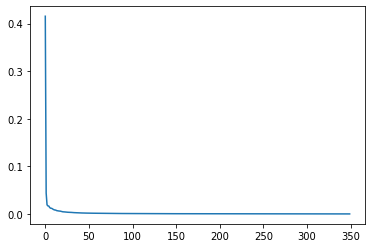

In [27]:
pca = PCA(n_components=350)
pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)

In [28]:

pca = PCA(n_components=50)
pca.fit_transform(X_train)
print('here')
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
svclassifier = SVC(kernel='linear', C=1e0, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)
print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

here
---------------Scores on train---------------
[[898 300]
 [448 307]]
             precision    recall  f1-score   support

        0.0       0.67      0.75      0.71      1198
        1.0       0.51      0.41      0.45       755

avg / total       0.60      0.62      0.61      1953

1953 607.0
0.45080763582966227
---------------Scores on test---------------
[[224 114]
 [ 93  58]]
             precision    recall  f1-score   support

        0.0       0.71      0.66      0.68       338
        1.0       0.34      0.38      0.36       151

avg / total       0.59      0.58      0.58       489

489 151.0
0.3591331269349845


In [11]:
svclassifier = SVC(kernel='linear', C=1e-1, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)
print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[924 316]
 [411 298]]
             precision    recall  f1-score   support

        0.0       0.69      0.75      0.72      1240
        1.0       0.49      0.42      0.45       709

avg / total       0.62      0.63      0.62      1949

1949 614.0
0.45049130763416473
---------------Scores on test---------------
[[242 102]
 [ 81  63]]
             precision    recall  f1-score   support

        0.0       0.75      0.70      0.73       344
        1.0       0.38      0.44      0.41       144

avg / total       0.64      0.62      0.63       488

488 144.0
0.4077669902912621
